In [1]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

Connecting anneurai@datajoint.internationalbrainlab.org:3306


In [6]:
## GET WEIGHT AND WATER DATA FOR ALL IBL SUBJECTS
subj = subject.Subject * subject.SubjectLab & \
        (subject.SubjectProject & 'subject_project = "ibl_neuropixel_brainwide_01"') 

# average watering and weight per session date
weight_with_date = subj * action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date)
avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)')
water_with_date = action.WaterAdministration.proj('watertype_name', 'water_administered', 'adlib',
                                                  session_date='DATE(administration_time)')
water_date = (dj.U('subject_uuid', 'session_date') & water_with_date)
total_water_date = water_date.aggr(water_with_date, total_water='SUM(water_administered)', 
                                   watertype="GROUP_CONCAT(DISTINCT watertype_name SEPARATOR '; ')", 
                                   adlib='MAX(adlib)')\

# combine all
b = subj  * avg_weight_date * total_water_date
b = b.proj('subject_nickname', 'subject_birth_date','sex', 'lab_name', 'avg_weight', 'total_water', 'watertype')
df = pd.DataFrame(b.fetch(as_dict=True))

# errors in the database; throw away crazy weights
df = df[~(df['avg_weight'] > 80)] 
df = df[~(df['avg_weight'] < 10)] 

In [7]:
# FOR EACH LAB, WHAT'S THE WEEKEND WATER REGIME?
lab_watermap = {}
for name, group in df.groupby(['lab_name']):
    #print(name)
    #print(group.watertype.unique())
    matching = [s for s in group.watertype if "Citric" in s]
    if not len(matching) == 0:
        lab_watermap.update({name:'CA'})
    else:
        lab_watermap.update({name:'restr'})

df['weekend_water_regime'] = df['lab_name'].map(lab_watermap)
df.weekend_water_regime.unique()

array(['restr', 'CA'], dtype=object)

In [8]:
## ADD INFO ABOUT WATER RESTRICTIONS PER MOUSE
weight_normalized = pd.DataFrame([])
for index, sjdatgr in df.groupby(['subject_nickname']):
    sjdat = sjdatgr.copy() # avoid copy warnings
    
    # add normalized weights (from mean per sj) and days from first weighing
    # sjdat['norm_weight'] = sjdat['avg_weight'] / sjdat['avg_weight'].mean()
    sjdat['days_weight'] = sjdat['session_date'] - sjdat['session_date'].min()
    
    # FOR EACH ANIMAL, ADD THEIR WATER RESTRICTION DATES AND REFERENCE WEIGHT
    subj_q = (subject.Subject & 'subject_nickname="%s"'%index) \
                & ( subject.SubjectLab & 'lab_name="%s"'%sjdat.lab_name.unique().item())
    restrictions = (action.WaterRestriction & subj_q).proj(
        'reference_weight',
        restriction_start_date='DATE(restriction_start_time)', 
        restriction_end_date='DATE(restriction_end_time)')
    restrictions = restrictions.fetch(format='frame').reset_index()
    
    # MAKE A NEW COLUMN THAT INDICATES THE START AND END OF WATER RESTRICTION
    if len(restrictions) > 0:
        
        # TAKE ONLY THE FIRST WATER RESTRICTION
        if len(restrictions) > 1:
            restrictions = restrictions.sort_values(by=['restriction_start_date']).head(n=1)
            
        if any(restrictions.restriction_end_date.isnull()):
            # print(subj_q.fetch1('subject_nickname'))
            print('%s''s first WR has no end date'%subj_q.fetch1('subject_nickname'))
        else:

            # look at weight curves as a function the animal's reference weight
            sjdat['norm_weight'] = sjdat['avg_weight'] / restrictions.reference_weight.item()
            
            # new date axis, linearly spaced
            restr_dates_linear = pd.DataFrame(pd.date_range(restrictions.restriction_start_date.item(), 
                                            restrictions.restriction_end_date.item()
                                                        )).reset_index().rename(columns={'index': 'day_restr', 0: 'session_date'})
            # ensure these are the same format before merge
            restr_dates_linear['session_date'] = restr_dates_linear['session_date'].dt.date
            # sjdat['session_date'] = sjdat['session_date'].dt.date
            sjdat = sjdat.merge(restr_dates_linear.set_index('session_date'), on=['session_date'])
            weight_normalized = weight_normalized.append(sjdat)

    else:
        print('%s has no WRs logged'%subj_q.fetch1('subject_nickname'))

# make into a new dataframe
df = weight_normalized.copy()

CSH_ZAD_002s first WR has no end date
CSH_ZAD_005s first WR has no end date
CSH_ZAD_006s first WR has no end date
CSH_ZAD_007s first WR has no end date
CSH_ZAD_010s first WR has no end date
CSH_ZAD_011s first WR has no end date
CSH_ZAD_015s first WR has no end date
CSH_ZAD_016s first WR has no end date
CSH_ZAD_017s first WR has no end date
CSH_ZAD_018s first WR has no end date
CSH_ZAD_019s first WR has no end date
CSH_ZAD_021s first WR has no end date
CSH_ZAD_022s first WR has no end date
CSH_ZAD_024s first WR has no end date
CSH_ZAD_23s first WR has no end date
CSK-IBL-002s first WR has no end date
CSK-IBL-004s first WR has no end date
DY_008s first WR has no end date
DY_009s first WR has no end date
DY_010s first WR has no end date
DY_011s first WR has no end date
DY_012s first WR has no end date
DY_013s first WR has no end date
DY_014s first WR has no end date
DY_015s first WR has no end date
IBL_001s first WR has no end date
IBL_002s first WR has no end date
IBL_003s first WR has n

In [13]:
# compute age range
df['session_age'] = (df.session_date - df.subject_birth_date)

## ADD SOME MORE USEFUL INFO - group by week, from Saturday to Friday
df['session_date'] = pd.to_datetime(df.session_date)
df['week_number']  = df['session_date'].dt.week
df['weekday_name'] = df['session_date'].dt.day_name()
df['days_weight']  = df['days_weight'].dt.days

df.session_age.describe()

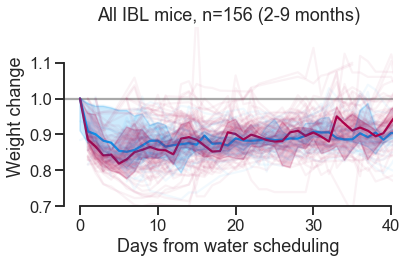

In [39]:
## NOW PLOT

condition_order = [ "restr", "CA"]
palette = sns.xkcd_palette(['azure', 'raspberry'])
f, ax = plt.subplots(ncols=1, nrows=1, figsize=[6, 4])

# df_group = df.groupby(['lab_name', 'day_restr', 'weekend_water_regime'])['avg_weight'].mean().reset_index()
# sns.lineplot(data=df_group, x='day_restr', y='avg_weight', hue='weekend_water_regime', 
#                  palette=palette, hue_order=condition_order, ax=ax[0], legend=False)
# ax[0].set_xlim([-2, 40])

df_group = df.groupby(['lab_name', 'day_restr', 'weekend_water_regime'])['norm_weight'].mean().reset_index()
sns.lineplot(data=df_group, x='day_restr', y='norm_weight', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order, ax=ax, legend=False, 
                err_style='band', estimator=np.median)
sns.lineplot(data=df, x='day_restr', y='norm_weight', hue='weekend_water_regime', 
                 palette=palette, hue_order=condition_order, ax=ax, legend=False, 
                estimator=None, units='subject_nickname', alpha=0.05)
ax.set_xlim([-2, 40.2])
ax.set_ylim([0.7, 1.2])
ax.axhline(y=1, color='darkgrey', zorder=-100)
ax.set_title('All IBL mice, n=%d (2-9 months)'%df.subject_uuid.nunique())
ax.set(xlabel='Days from water scheduling', ylabel='Weight change')

sns.despine(trim=True)
f.tight_layout()
f.savefig(os.path.join(figpath, "ibl_weightcurves.pdf"))

In [19]:
df.session_age.describe()

count                        5607
mean     126 days 07:20:42.375601
std       37 days 23:11:51.163320
min              43 days 00:00:00
25%              98 days 00:00:00
50%             119 days 00:00:00
75%             149 days 00:00:00
max             275 days 00:00:00
Name: session_age, dtype: object